In [ ]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
np.random.seed(2)
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from tensorflow.keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPool2D, Dropout
from tensorflow.keras.optimizers.legacy import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping


In [ ]:
from PIL import Image, ImageChops, ImageEnhance
import os
import itertools

In [ ]:
def convert_to_ela_image(path, quality):
    temp_filename = 'temp_file_name.jpg'
    ela_filename = 'temp_ela.png'

    image = Image.open(path).convert('RGB')
    image.save(temp_filename, 'JPEG', quality = quality)
    temp_image = Image.open(temp_filename)

    ela_image = ImageChops.difference(image, temp_image)

    extrema = ela_image.getextrema()
    max_diff = max([ex[1] for ex in extrema])
    if max_diff == 0:
        max_diff = 1
    scale = 255.0 / max_diff

    ela_image = ImageEnhance.Brightness(ela_image).enhance(scale)

    return ela_image

In [ ]:
! pip install kaggle

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"vathsa11","key":"721f6b3357189fc3132f1a46daf7ebf0"}'}

In [ ]:
!rm -r ~/.kaggle
!mkdir ~/.kaggle
!mv ./kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

rm: cannot remove '/root/.kaggle': No such file or directory


In [ ]:
!kaggle datasets download -d divg07/casia-20-image-tampering-detection-dataset

100% 2.56G/2.56G [01:55<00:00, 28.9MB/s]
100% 2.56G/2.56G [01:55<00:00, 23.8MB/s]


In [ ]:
import zipfile
zip_ref = zipfile.ZipFile('casia-20-image-tampering-detection-dataset.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close()

In [ ]:
image_size = (128, 128)

In [ ]:
def prepare_image(image_path):
    return np.array(convert_to_ela_image(image_path, 90).resize(image_size)).flatten() / 255.0

In [ ]:
X = [] # for stroing ELA converted images
Y = [] # stores 0 for fake and 1 for real

In [ ]:
import random
path = 'CASIA2/Au/'
for dirname, _, filenames in os.walk(path):
    for filename in filenames:
        if filename.endswith('jpg') or filename.endswith('png'):
            full_path = os.path.join(dirname, filename)
            X.append(prepare_image(full_path))
            Y.append(1)
            if len(Y) % 500 == 0:
                print(f'Processing {len(Y)} images')

random.shuffle(X)
X = X[:2100]
Y = Y[:2100]
print(len(X), len(Y))

Processing 500 images
Processing 1500 images
Processing 2000 images
Processing 2500 images
Processing 3000 images
Processing 3500 images
Processing 4000 images
Processing 4500 images
Processing 5000 images
Processing 5500 images
Processing 6000 images
Processing 6500 images
Processing 7000 images
2100 2100


In [ ]:
path = 'CASIA2/Tp/'
for dirname, _, filenames in os.walk(path):
    for filename in filenames:
        if filename.endswith('jpg') or filename.endswith('png'):
            full_path = os.path.join(dirname, filename)
            X.append(prepare_image(full_path))
            Y.append(0)
            if len(Y) % 500 == 0:
                print(f'Processing {len(Y)} images')

print(len(X), len(Y))

Processing 2500 images
Processing 3000 images
Processing 3500 images
Processing 4000 images
4164 4164


In [ ]:
X = np.array(X)
Y = to_categorical(Y, 2)
X = X.reshape(-1, 128, 128, 3)

In [ ]:
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size = 0.2, random_state=5)
X = X.reshape(-1,1,1,1)
print(len(X_train), len(Y_train))
print(len(X_val), len(Y_val))

3331 3331
833 833


In [ ]:
def build_model():
    model = Sequential()
    model.add(Conv2D(filters = 32, kernel_size = (5, 5), padding = 'valid', activation = 'relu', input_shape = (128, 128, 3)))
    model.add(Conv2D(filters = 32, kernel_size = (5, 5), padding = 'valid', activation = 'relu', input_shape = (128, 128, 3)))
    model.add(MaxPool2D(pool_size = (2, 2)))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(256, activation = 'relu'))
    model.add(Dropout(0.5))
    model.add(Dense(2, activation = 'softmax'))
    return model

In [ ]:
model = build_model()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 124, 124, 32)      2432      
                                                                 
 conv2d_1 (Conv2D)           (None, 120, 120, 32)      25632     
                                                                 
 max_pooling2d (MaxPooling2  (None, 60, 60, 32)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 60, 60, 32)        0         
                                                                 
 flatten (Flatten)           (None, 115200)            0         
                                                                 
 dense (Dense)               (None, 256)               29491456  
                                                        

In [ ]:
init_lr = 0.0001
optimizer = Adam(lr = init_lr, decay = init_lr/epochs)

/usr/local/lib/python3.10/dist-packages/keras/src/optimizers/legacy/adam.py:118: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [ ]:
model.compile(optimizer = optimizer, loss = 'binary_crossentropy', metrics = ['accuracy'])

In [ ]:
early_stopping = EarlyStopping(monitor = 'val_acc',
                              min_delta = 0,
                              patience = 2,
                              verbose = 0,
                              mode = 'auto')

In [ ]:
epochs = 30
batch_size = 32

In [ ]:
hist = model.fit(X_train,
                 Y_train,
                 batch_size = batch_size,
                 epochs = epochs,
                validation_data = (X_val, Y_val),
                callbacks = [early_stopping])

Epoch 1/30
105/105 [==============================] - ETA: 0s - loss: 0.4928 - accuracy: 0.7472

105/105 [==============================] - 343s 3s/step - loss: 0.4928 - accuracy: 0.7472 - val_loss: 0.4253 - val_accuracy: 0.8127
Epoch 2/30
105/105 [==============================] - ETA: 0s - loss: 0.3188 - accuracy: 0.8892

105/105 [==============================] - 338s 3s/step - loss: 0.3188 - accuracy: 0.8892 - val_loss: 0.3339 - val_accuracy: 0.8691
Epoch 3/30
105/105 [==============================] - ETA: 0s - loss: 0.2731 - accuracy: 0.9051

105/105 [==============================] - 344s 3s/step - loss: 0.2731 - accuracy: 0.9051 - val_loss: 0.3044 - val_accuracy: 0.8872
Epoch 4/30
105/105 [==============================] - ETA: 0s - loss: 0.2489 - accuracy: 0.9084

105/105 [==============================] - 337s 3s/step - loss: 0.2489 - accuracy: 0.9084 - val_loss: 0.2763 - val_accuracy: 0.9004
Epoch 5/30
105/105 [==============================] - ETA: 0s - loss: 0.2222 - accuracy: 0.9183

105/105 [==============================] - 346s 3s/step - loss: 0.2222 - accuracy: 0.9183 - val_loss: 0.2883 - val_accuracy: 0.8824
Epoch 6/30
105/105 [==============================] - ETA: 0s - loss: 0.2380 - accuracy: 0.9096

105/105 [==============================] - 351s 3s/step - loss: 0.2380 - accuracy: 0.9096 - val_loss: 0.2456 - val_accuracy: 0.9064
Epoch 7/30
105/105 [==============================] - ETA: 0s - loss: 0.1911 - accuracy: 0.9292

105/105 [==============================] - 356s 3s/step - loss: 0.1911 - accuracy: 0.9292 - val_loss: 0.2418 - val_accuracy: 0.9064
Epoch 8/30
105/105 [==============================] - ETA: 0s - loss: 0.1844 - accuracy: 0.9292

105/105 [==============================] - 343s 3s/step - loss: 0.1844 - accuracy: 0.9292 - val_loss: 0.2368 - val_accuracy: 0.9076
Epoch 9/30
105/105 [==============================] - ETA: 0s - loss: 0.1670 - accuracy: 0.9406

105/105 [==============================] - 342s 3s/step - loss: 0.1670 - accuracy: 0.9406 - val_loss: 0.2296 - val_accuracy: 0.9136
Epoch 10/30
105/105 [==============================] - ETA: 0s - loss: 0.1599 - accuracy: 0.9412

105/105 [==============================] - 338s 3s/step - loss: 0.1599 - accuracy: 0.9412 - val_loss: 0.2315 - val_accuracy: 0.9124
Epoch 11/30
105/105 [==============================] - ETA: 0s - loss: 0.1374 - accuracy: 0.9493

105/105 [==============================] - 340s 3s/step - loss: 0.1374 - accuracy: 0.9493 - val_loss: 0.2444 - val_accuracy: 0.9088
Epoch 12/30
105/105 [==============================] - ETA: 0s - loss: 0.1363 - accuracy: 0.9466

105/105 [==============================] - 339s 3s/step - loss: 0.1363 - accuracy: 0.9466 - val_loss: 0.2217 - val_accuracy: 0.9208
Epoch 13/30
105/105 [==============================] - ETA: 0s - loss: 0.1191 - accuracy: 0.9580

105/105 [==============================] - 341s 3s/step - loss: 0.1191 - accuracy: 0.9580 - val_loss: 0.3019 - val_accuracy: 0.8691
Epoch 14/30
105/105 [==============================] - ETA: 0s - loss: 0.1222 - accuracy: 0.9562

105/105 [==============================] - 337s 3s/step - loss: 0.1222 - accuracy: 0.9562 - val_loss: 0.2239 - val_accuracy: 0.9160
Epoch 15/30
105/105 [==============================] - ETA: 0s - loss: 0.1109 - accuracy: 0.9604

105/105 [==============================] - 335s 3s/step - loss: 0.1109 - accuracy: 0.9604 - val_loss: 0.2319 - val_accuracy: 0.9172
Epoch 16/30
105/105 [==============================] - ETA: 0s - loss: 0.0948 - accuracy: 0.9655

105/105 [==============================] - 342s 3s/step - loss: 0.0948 - accuracy: 0.9655 - val_loss: 0.2190 - val_accuracy: 0.9232
Epoch 17/30
105/105 [==============================] - ETA: 0s - loss: 0.0877 - accuracy: 0.9697

105/105 [==============================] - 338s 3s/step - loss: 0.0877 - accuracy: 0.9697 - val_loss: 0.2350 - val_accuracy: 0.9220
Epoch 18/30
105/105 [==============================] - ETA: 0s - loss: 0.0759 - accuracy: 0.9724

105/105 [==============================] - 338s 3s/step - loss: 0.0759 - accuracy: 0.9724 - val_loss: 0.2358 - val_accuracy: 0.9172
Epoch 19/30
105/105 [==============================] - ETA: 0s - loss: 0.0764 - accuracy: 0.9745

105/105 [==============================] - 339s 3s/step - loss: 0.0764 - accuracy: 0.9745 - val_loss: 0.2211 - val_accuracy: 0.9196
Epoch 20/30
105/105 [==============================] - ETA: 0s - loss: 0.0675 - accuracy: 0.9775

105/105 [==============================] - 339s 3s/step - loss: 0.0675 - accuracy: 0.9775 - val_loss: 0.2442 - val_accuracy: 0.9172
Epoch 21/30
105/105 [==============================] - ETA: 0s - loss: 0.0666 - accuracy: 0.9790

105/105 [==============================] - 341s 3s/step - loss: 0.0666 - accuracy: 0.9790 - val_loss: 0.2351 - val_accuracy: 0.9220
Epoch 22/30
105/105 [==============================] - ETA: 0s - loss: 0.0621 - accuracy: 0.9811

105/105 [==============================] - 342s 3s/step - loss: 0.0621 - accuracy: 0.9811 - val_loss: 0.2770 - val_accuracy: 0.9136
Epoch 23/30
105/105 [==============================] - ETA: 0s - loss: 0.0529 - accuracy: 0.9826

105/105 [==============================] - 343s 3s/step - loss: 0.0529 - accuracy: 0.9826 - val_loss: 0.2448 - val_accuracy: 0.9136
Epoch 24/30
105/105 [==============================] - ETA: 0s - loss: 0.0492 - accuracy: 0.9856

105/105 [==============================] - 338s 3s/step - loss: 0.0492 - accuracy: 0.9856 - val_loss: 0.2845 - val_accuracy: 0.9136
Epoch 25/30
105/105 [==============================] - ETA: 0s - loss: 0.0484 - accuracy: 0.9847

105/105 [==============================] - 341s 3s/step - loss: 0.0484 - accuracy: 0.9847 - val_loss: 0.3055 - val_accuracy: 0.9136
Epoch 26/30
105/105 [==============================] - ETA: 0s - loss: 0.0446 - accuracy: 0.9859

105/105 [==============================] - 341s 3s/step - loss: 0.0446 - accuracy: 0.9859 - val_loss: 0.5837 - val_accuracy: 0.8571
Epoch 27/30
105/105 [==============================] - ETA: 0s - loss: 0.0531 - accuracy: 0.9844

105/105 [==============================] - 341s 3s/step - loss: 0.0531 - accuracy: 0.9844 - val_loss: 0.2708 - val_accuracy: 0.9124
Epoch 28/30
105/105 [==============================] - ETA: 0s - loss: 0.0373 - accuracy: 0.9871

105/105 [==============================] - 340s 3s/step - loss: 0.0373 - accuracy: 0.9871 - val_loss: 0.2914 - val_accuracy: 0.9112
Epoch 29/30
105/105 [==============================] - ETA: 0s - loss: 0.0357 - accuracy: 0.9895

105/105 [==============================] - 339s 3s/step - loss: 0.0357 - accuracy: 0.9895 - val_loss: 0.3064 - val_accuracy: 0.9064
Epoch 30/30
105/105 [==============================] - ETA: 0s - loss: 0.0352 - accuracy: 0.9889

105/105 [==============================] - 341s 3s/step - loss: 0.0352 - accuracy: 0.9889 - val_loss: 0.2909 - val_accuracy: 0.9124


In [ ]:
model.save('model_casia_run1.h5')

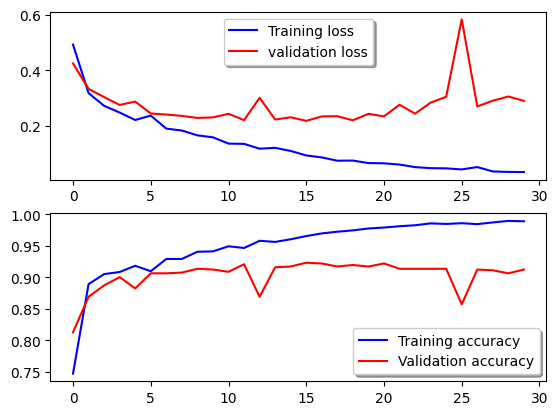

In [ ]:
# loss and accuracy curves for training and validation
fig, ax = plt.subplots(2,1)
ax[0].plot(hist.history['loss'], color='b', label="Training loss")
ax[0].plot(hist.history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(hist.history['accuracy'], color='b', label="Training accuracy")
ax[1].plot(hist.history['val_accuracy'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)

In [ ]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

27/27 [==============================] - 19s 683ms/step


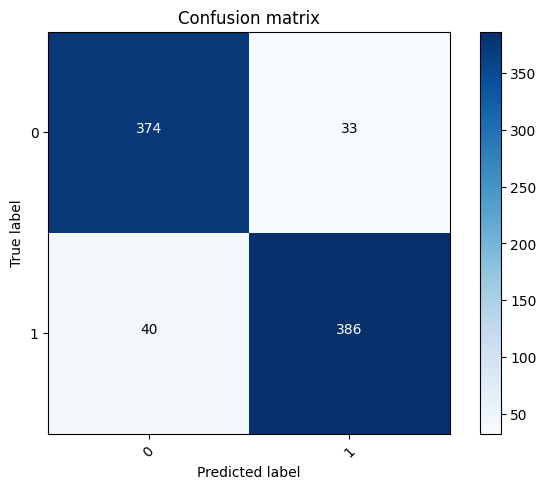

In [ ]:
Y_pred = model.predict(X_val)
Y_pred_classes = np.argmax(Y_pred,axis = 1)
Y_true = np.argmax(Y_val,axis = 1)
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes)
plot_confusion_matrix(confusion_mtx, classes = range(2))

In [ ]:
class_names = ['fake', 'real']

In [ ]:
real_image_path = 'CASIA2/Au/Au_ani_00001.jpg'
image = prepare_image(real_image_path)
image = image.reshape(-1, 128, 128, 3)
y_pred = model.predict(image)
y_pred_class = np.argmax(y_pred, axis = 1)[0]
print(f'Class: {class_names[y_pred_class]} Confidence: {np.amax(y_pred) * 100:0.2f}')

1/1 [==============================] - 0s 64ms/step
Class: real Confidence: 100.00


In [ ]:
fake_image_path = 'CASIA2/Tp/Tp_D_NRN_S_N_ani10171_ani00001_12458.jpg'
image = prepare_image(fake_image_path)
image = image.reshape(-1, 128, 128, 3)
y_pred = model.predict(image)
y_pred_class = np.argmax(y_pred, axis = 1)[0]
print(f'Class: {class_names[y_pred_class]} Confidence: {np.amax(y_pred) * 100:0.2f}')

1/1 [==============================] - 0s 59ms/step
Class: fake Confidence: 99.91


In [ ]:
fake_image = os.listdir('CASIA2/Tp/')
correct = 0
total = 0
for file_name in fake_image:
    if file_name.endswith('jpg') or filename.endswith('png'):
        fake_image_path = os.path.join('CASIA2/Tp/', file_name)
        image = prepare_image(fake_image_path)
        image = image.reshape(-1, 128, 128, 3)
        y_pred = model.predict(image)
        y_pred_class = np.argmax(y_pred, axis = 1)[0]
        total += 1
        if y_pred_class == 0:
            correct += 1

1/1 [==============================] - 0s 50ms/step


In [ ]:
print(f'Total: {total}, Correct: {correct}, Acc: {correct / total * 100.0}')

Total: 2064, Correct: 2025, Acc: 98.11046511627907


In [ ]:
real_image = os.listdir('CASIA2/Au/')
correct_r = 0
total_r = 0
for file_name in real_image:
    if file_name.endswith('jpg') or filename.endswith('png'):
        real_image_path = os.path.join('CASIA2/Au/', file_name)
        image = prepare_image(real_image_path)
        image = image.reshape(-1, 128, 128, 3)
        y_pred = model.predict(image)
        y_pred_class = np.argmax(y_pred, axis = 1)[0]
        total_r += 1
        if y_pred_class == 1:
            correct_r += 1

Streaming output truncated to the last 5000 lines.
1/1 [==============================] - 0s 54ms/step


In [ ]:
correct += correct_r
total += total_r
print(f'Total: {total_r}, Correct: {correct_r}, Acc: {correct_r / total_r * 100.0}')
print(f'Total: {total}, Correct: {correct}, Acc: {correct / total * 100.0}')

Total: 7437, Correct: 6920, Acc: 93.04827215274976
Total: 9501, Correct: 8945, Acc: 94.14798442269235
